# 1. Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import textwrap
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [3]:
import import_ipynb
import utils

importing Jupyter notebook from utils.ipynb


# 2. Data retrieval

## 2.1 US data

In [4]:
US_price,abs_return_US,US_index_price,abs_return_index_US=utils.CSV_price('US',2006,2019,False)

In [5]:
US_VWAP,abs_return_VWAP_US,US_index_VWAP,abs_return_VWAP_index_US=utils.CSV_price('US',2006,2019,True)

C:\Users\eric.li\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [6]:
US_EPS =utils.CSV_EPS("US",2006,2019)

In [7]:
US1=utils.CSV_fundamentals("US",US_price,US_EPS,1,120,0.005,True)

## 2.2 Europe data

In [8]:
Europe_price,abs_return_Europe,Europe_index_price,abs_return_index_Europe=utils.CSV_price_orig('Europe',2006,2019,False)

In [9]:
Europe_VWAP,abs_return_VWAP_Europe,Europe_index_VWAP,abs_return_VWAP_index_Europe=utils.CSV_price_orig('Europe',2006,2019,True)

In [10]:
Europe_EPS =utils.CSV_EPS("Europe",2006,2019)

In [11]:
Europe2=utils.CSV_fundamentals("Europe",Europe_price,Europe_EPS,2,120,0.005,True)

## 2.3 Asia data

In [12]:
Asia_price,abs_return_Asia,Asia_index_price,abs_return_index_Asia=utils.CSV_price_orig('Asia',2006,2019,False)

In [13]:
Asia_VWAP,abs_return_VWAP_Asia,Europe_index_Asia,abs_return_VWAP_index_Asia=utils.CSV_price_orig('Asia',2006,2019,False)

In [14]:
Asia_EPS =utils.CSV_EPS("Asia",2006,2019)

In [51]:
Asia2=utils.CSV_fundamentals("Asia",Asia_price,Asia_EPS,2,120,0.005,False)

                 Date            Orig date  Market cap      Volume  \
Ticker                                                               
8270 JP    2007-01-05  2007-01-05 00:00:00   2504.8126    6.074805   
3337 JP    2007-01-05  2007-01-05 00:00:00   1588.7307    6.418745   
7453 JP    2007-01-05  2007-01-05 00:00:00   2169.6636   12.349353   
8267 JP    2007-01-05  2007-01-05 00:00:00  18080.8233   53.995287   
8273 JP    2007-01-05  2007-01-05 00:00:00   2217.7714    3.075023   
SPH SP     2007-01-08  2007-01-08 00:00:00   4636.6944    7.681267   
8028 JP    2007-01-09  2007-01-09 00:00:00   2761.4465    5.143418   
2880 TT    2007-01-09  2007-01-09 00:00:00   4474.4603    5.319704   
2651 JP    2007-01-09  2007-01-09 00:00:00   3860.7499    8.776672   
9843 JP    2007-01-09  2007-01-09 00:00:00   2387.4372   10.185021   
3382 JP    2007-01-09  2007-01-09 00:00:00  31255.0821   90.539858   
6136 JP    2007-01-10  2007-01-09 00:00:00   1562.2321    5.028216   
2883 TT    2007-01-1

                 Date            Orig date  Market cap      Volume  \
Ticker                                                               
7453 JP    2007-01-05  2007-01-05 00:00:00   2169.6636   12.349353   
8273 JP    2007-01-05  2007-01-05 00:00:00   2217.7714    3.075023   
8267 JP    2007-01-05  2007-01-05 00:00:00  18080.8233   53.995287   
3337 JP    2007-01-05  2007-01-05 00:00:00   1588.7307    6.418745   
8270 JP    2007-01-05  2007-01-05 00:00:00   2504.8126    6.074805   
SPH SP     2007-01-08  2007-01-08 00:00:00   4636.6944    7.681267   
3382 JP    2007-01-09  2007-01-09 00:00:00  31255.0821   90.539858   
8028 JP    2007-01-09  2007-01-09 00:00:00   2761.4465    5.143418   
2651 JP    2007-01-09  2007-01-09 00:00:00   3860.7499    8.776672   
9843 JP    2007-01-09  2007-01-09 00:00:00   2387.4372   10.185021   
2880 TT    2007-01-09  2007-01-09 00:00:00   4474.4603    5.319704   
6136 JP    2007-01-10  2007-01-09 00:00:00   1562.2321    5.028216   
2337 JP    2007-01-1


                  Date            Orig date  Market cap      Volume  \
Ticker                                                                
3833 HK    01/Apr/2008  2008-04-01 00:00:00   1393.3753    4.480275   
3037 TT    01/Apr/2008  2008-04-01 00:00:00   1464.8493    8.583705   
7545 JP    01/Apr/2008  2008-04-01 00:00:00    788.0312    4.294504   
034220 KS  01/Apr/2008  2008-03-31 00:00:00  16049.3522  157.965503   
69 HK      01/Apr/2008  2008-04-01 00:00:00   7260.5884    6.358145   
2866 HK    01/Apr/2008  2008-04-01 00:00:00   8929.3093   28.403117   
MIS AU     01/Apr/2008  2008-04-01 00:00:00   1173.7745    4.718598   
028670 KS  01/Apr/2008  2008-03-31 00:00:00   4486.9115  126.269075   
3704 TT    01/Apr/2008  2008-04-01 00:00:00    610.4263    4.364360   
694 HK     01/Apr/2008  2008-04-01 00:00:00   3611.0103   11.710668   
6505 TT    01/Apr/2009  2009-04-01 00:00:00  18208.8398    5.903339   
036570 KS  01/Apr/2009  2009-03-31 00:00:00   1413.8008    9.619487   
02867


                  Date    Orig date  Market cap      Volume  \
Ticker                                                        
3833 HK    01/Apr/2008  01/Apr/2008   1393.3753    4.480275   
3037 TT    01/Apr/2008  01/Apr/2008   1464.8493    8.583705   
7545 JP    01/Apr/2008  01/Apr/2008    788.0312    4.294504   
034220 KS  01/Apr/2008  31/Mar/2008  16049.3522  157.965503   
69 HK      01/Apr/2008  01/Apr/2008   7260.5884    6.358145   
2866 HK    01/Apr/2008  01/Apr/2008   8929.3093   28.403117   
MIS AU     01/Apr/2008  01/Apr/2008   1173.7745    4.718598   
028670 KS  01/Apr/2008  31/Mar/2008   4486.9115  126.269075   
3704 TT    01/Apr/2008  01/Apr/2008    610.4263    4.364360   
694 HK     01/Apr/2008  01/Apr/2008   3611.0103   11.710668   
6505 TT    01/Apr/2009  01/Apr/2009  18208.8398    5.903339   
036570 KS  01/Apr/2009  31/Mar/2009   1413.8008    9.619487   
028670 KS  01/Apr/2009  31/Mar/2009   1394.2170   19.434180   
2303 TT    01/Apr/2009  31/Mar/2009   4251.1283   14.3


                  Date    Orig date  Market cap     Volume  \
Ticker                                                       
000060 KS  25/Jul/2007  25/Jul/2007    938.7514  10.767585   
000060 KS  24/Oct/2007  24/Oct/2007   1476.6994   9.660166   
000060 KS  14/Feb/2008  14/Feb/2008   1303.9166   7.084042   
000060 KS  30/Jun/2009  30/Jun/2009    612.9917   5.048203   
000060 KS  30/Jun/2010  29/Jun/2010    806.3273   3.679278   
000060 KS  30/Aug/2011  29/Aug/2011    781.2167   6.857327   
000060 KS  29/Oct/2012  29/Oct/2012   1290.7430   5.890103   
000060 KS  04/Mar/2013  04/Mar/2013   1053.3962   4.669587   
000060 KS  25/Apr/2013  24/Apr/2013   1063.9586   3.723315   
000060 KS  14/Aug/2014  14/Aug/2014   1324.5529   3.084412   
000060 KS  18/May/2015  15/May/2015   1402.7907   6.290021   
000060 KS  18/Aug/2015  17/Aug/2015   1420.5116   3.027721   
000060 KS  15/Aug/2017  14/Aug/2017   2327.3149   4.466701   
000060 KS  15/Nov/2017  14/Nov/2017   2473.8353   4.676833   
000060 


                                                      Date    Orig date  \
000060 KS 25/Jul/2007 24/Oct/2007 28/Sep/2007  25/Jul/2007  25/Jul/2007   
          24/Oct/2007 14/Feb/2008 31/Dec/2007  24/Oct/2007  24/Oct/2007   
          14/Feb/2008 30/Jun/2009 31/Mar/2008  14/Feb/2008  14/Feb/2008   
          30/Jun/2009 30/Jun/2010 30/Jun/2009  30/Jun/2009  30/Jun/2009   
          30/Jun/2010 30/Aug/2011 30/Jun/2010  30/Jun/2010  29/Jun/2010   
          30/Aug/2011 29/Oct/2012 30/Sep/2011  30/Aug/2011  29/Aug/2011   
          29/Oct/2012 04/Mar/2013 31/Dec/2012  29/Oct/2012  29/Oct/2012   
          04/Mar/2013 25/Apr/2013 29/Mar/2013  04/Mar/2013  04/Mar/2013   
          25/Apr/2013 14/Aug/2014 28/Jun/2013  25/Apr/2013  24/Apr/2013   
          14/Aug/2014 18/May/2015 30/Sep/2014  14/Aug/2014  14/Aug/2014   
          18/May/2015 18/Aug/2015 30/Jun/2015  18/May/2015  15/May/2015   
          18/Aug/2015 15/Aug/2017 30/Sep/2015  18/Aug/2015  17/Aug/2015   
          15/Aug/2017 15


2020-01-06 14:19:23.741963



2020-01-06 14:20:36.920804



2020-01-06 14:20:56.695735



2020-01-06 14:21:34.742225


# 5 - Result

## 5.1 - Europe

In [88]:
Europe_orig=utils.signal(fundamental_df=Europe2,
                    price_df=Europe_price,
                    close_return_df=abs_return_Europe,
                    entry=2,
                    base=utils.signal_base(Europe2,{"EAR_n":[1,1000],"Revision_20":[0.03,1000]},
                                           {"EAR_n":[-1000,-2],"Revision_20":[-1000,-0.03],"Market cap":[5000,10000000]},
                                           (Europe_price,Europe_price,0,1,"abs")),
                    holding=30,
                    start=pd.Timestamp(2019,10,1),
                    end=pd.Timestamp(2019,12,30),
                    old_position=True,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [89]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_orig.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=60)

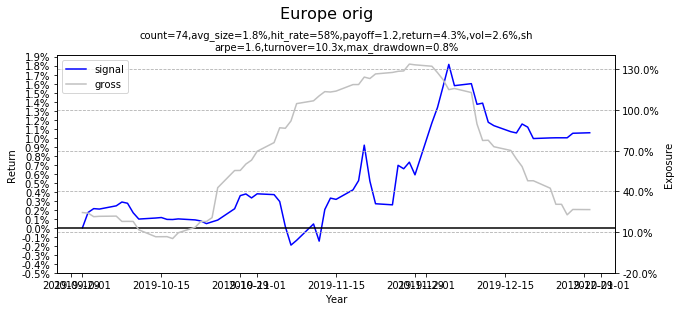

In [102]:
plot_signal("Europe orig", [10,4],Europe_orig.portfolio_account)

In [103]:
Europe_new=utils.signal(fundamental_df=Europe2,
                   price_df=Europe_VWAP,
                   close_return_df=abs_return_Europe,
                   entry=3,
                   base=utils.signal_base(Europe2,{"EAR_n":[2,1000],"Revision_real":[0.02,1000]},
                                           {"EAR_n":[-1000,-2],"Revision_real":[-1000,-0.02],"Market cap":[5000,10000000]},
                                           (Europe_price,Europe_price,0,1,"abs")),
                   holding=30,
                   start=pd.Timestamp(2019,10,1),
                   end=pd.Timestamp(2019,12,30),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(True,(0.02,0.05),(-0.05,-0.02),2),
                  early_exit=False)

In [104]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_new.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=60)

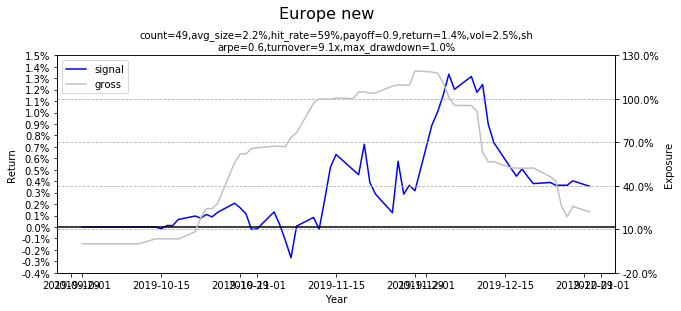

In [105]:
plot_signal("Europe new",[10,4],Europe_new.portfolio_account)

## 5.2 - US

In [89]:
US_orig=utils.signal(fundamental_df=US1,
                    price_df=US_price,
                    close_return_df=abs_return_US,
                    entry=2,
                    base=utils.signal_base(US1,{"EAR_n":[3,1000],"Revision_20":[0.05,1000]},
                                           {"EAR_n":[-1000,-2],"Revision_20":[-1000,-0.03],"Market cap":[5000,10000000]},
                                           (US_price,US_price,0,1,"abs")),
                    holding=30,
                    start=pd.Timestamp(2010,1,1),
                    end=pd.Timestamp(2019,12,30),
                    old_position=True,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [90]:
_long_US,_short_US,_alpha_US,_portfolio_US=US_orig.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=60)

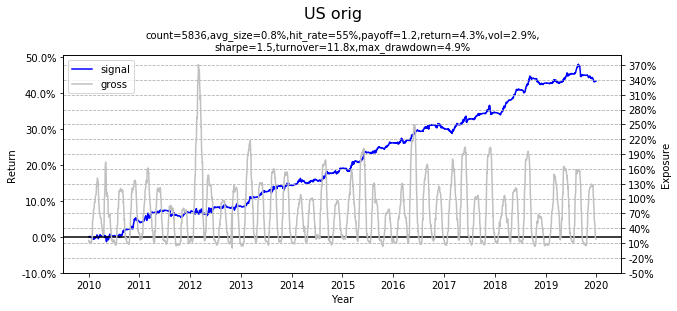

In [91]:
utils.plot_signal("US orig",[10,4],US_orig.portfolio_account)

In [94]:
a,b=US_orig.signal_df_date()

In [15]:
US_new=utils.signal(fundamental_df=US1,
              price_df=US_VWAP,
              close_return_df=abs_return_US,
              entry=2,
              base=utils.signal_base(US1,{"EAR_n":[2,1000],"Revision_real":[0.05,1000]},
                                           {"EAR_n":[-1000,-2],"Revision_real":[-1000,-0.03],"Market cap":[5000,10000000]},
                                           (US_price,US_price,0,1,"abs")),
              holding=30,
              start=pd.Timestamp(2010,1,1),
              end=pd.Timestamp(2019,12,30),
              old_position=True,
              new_signal=True,
              revision_adjust=(True,(0.05,0.2),(-0.03,-0.1),2),
              early_exit=False)

In [18]:
_long_US,_short_US,_alpha_US,_portfolio_US=US_new.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,0),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=60)

utils.ipynb:33: RuntimeWarning: divide by zero encountered in double_scalars
  "metadata": {},
utils.ipynb:34: RuntimeWarning: divide by zero encountered in double_scalars
  "outputs": [],


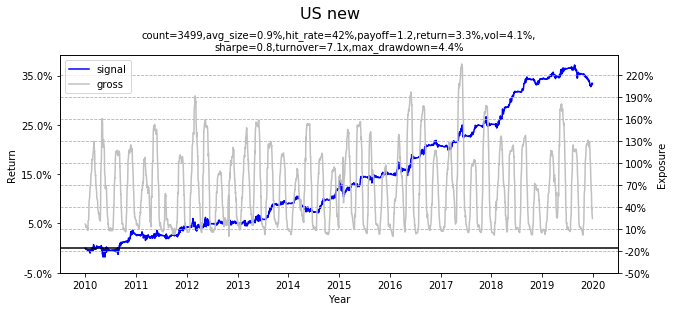

In [19]:
utils.plot_signal("US new",[10,4],US_new.portfolio_account)

In [29]:
US_orig.long_cache[2].iloc[:,30].dropna()

2013-08-02    0.008136
2013-08-05    0.008399
2013-08-06    0.008060
2013-08-07    0.007665
2013-08-08    0.007858
2013-08-09    0.008090
2013-08-12    0.008461
2013-08-13    0.008375
2013-08-14    0.008511
2013-08-15    0.008038
2013-08-16    0.008478
2013-08-19    0.008029
2013-08-20    0.007889
2013-08-21    0.007801
2013-08-22    0.007898
2013-08-23    0.007946
2013-08-26    0.007874
2013-08-27    0.007547
2013-08-28    0.007439
2013-08-29    0.007663
2013-08-30    0.007635
2013-09-02    0.007635
2013-09-03    0.007702
2013-09-04    0.008073
2013-09-05    0.008007
2013-09-06    0.007941
2013-09-09    0.008522
2013-09-10    0.008386
2013-09-11    0.008768
2013-09-12    0.008836
2013-09-13    0.008998
Name: (1537336D US, 01/Aug/2013, 30/Oct/2013, 30/Sep/2013), dtype: float64

## 5.3 Asia

In [113]:
Asia_orig=utils.signal(fundamental_df=Asia2,
                    price_df=Asia_price,
                    close_return_df=abs_return_Asia,
                    entry=2,
                    base=utils.signal_base(Asia2,{"EAR_n":[1,1000],"Revision_20":[0.02,1000]},
                                           None,
                                           (Asia_price,Asia_price,-1,3,"abs")),
                    holding=20,
                    start=pd.Timestamp(2019,10,1),
                    end=pd.Timestamp(2019,12,30),
                    old_position=True,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [114]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Asia_orig.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,0),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=50)

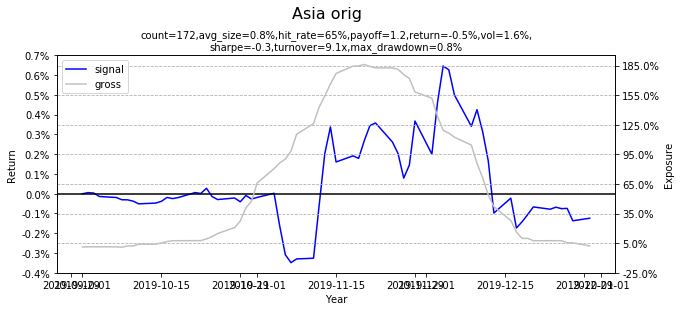

In [115]:
plot_signal("Asia orig",[10,4],Asia_orig.portfolio_account)

In [116]:
Asia_new=utils.signal(fundamental_df=Asia2,
                   price_df=Asia_VWAP,
                   close_return_df=abs_return_Asia,
                   entry=3,
                   base=utils.signal_base(Asia2,{"EAR_n":[1,1000],"Revision_real":[0.02,1000]},
                                           None,
                                           (Asia_price,Asia_price,-1,3,"abs")),                      
                   holding=20,
                   start=pd.Timestamp(2019,10,1),
                   end=pd.Timestamp(2019,12,30),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(True,(0.02,0.05),(-0.05,-0.02),2),
                  early_exit=False)

In [117]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Asia_new.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,0),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=25)

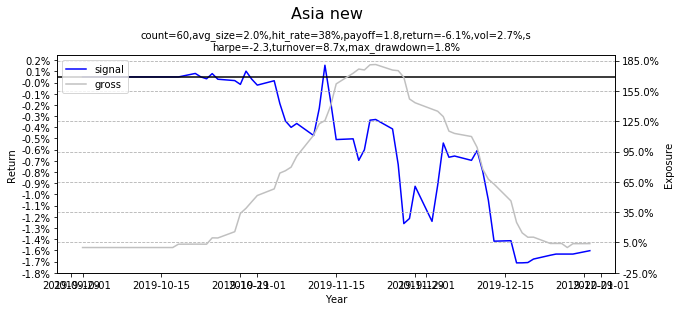

In [118]:
plot_signal("Asia new",[10,4],Asia_new.portfolio_account)

# 5 - Fitting choice

In [794]:
def fitting_df(long,EAR_list,revision_list,fundamental_df,price_df,EAR_period,holding,start,end,stop,gross,index_df,
               net_level,risk_parity,liquidity,capital,exclusive):
    '''
    Create a dataframe of sharpe and drawdown for different fitting variations
    EAR/revision list includes the upper bound
    '''
    year_list=range(start.year,end.year+1)
    EAR_list.sort()
    revision_list.sort()
    
    criteria_list_short=list(itertools.product(*[EAR_list[1:],revision_list[1:]]))
    criteria_list_long=list(itertools.product(*[EAR_list[:-1],revision_list[:-1]]))
    
    sharpe_dict={}
    dd_dict={}
    if exclusive:
        if long:
            for s in criteria_list_long:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=((s[0],EAR_list[EAR_list.index(s[0])+1]),\
                                                  (s[1],revision_list[revision_list.index(s[1])+1]),None,None),
                                   short_criteria=None,
                                   holding=holding,
                                   start=start,
                                   end=end)
                
                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[s]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[s]=dd_by_year(portfolio[-1][1],year_list)
                
        else:
            for s in criteria_list_short:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=None,
                                   short_criteria=((EAR_list[EAR_list.index(s[0])-1],s[0]),\
                                                   (revision_list[revision_list.index(s[1])-1],s[1]),None,(5000,10000000)),
                                   holding=holding,
                                   start=start,
                                   end=end)

                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[s]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[s]=dd_by_year(portfolio[-1][1],year_list)
    
    else:
        if long:
            for i in criteria_list_long:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=((i[0],10),(i[1],10),None,None),
                                   short_criteria=None,
                                   holding=holding,
                                   start=start,
                                   end=end)

                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[i]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[i]=dd_by_year(portfolio[-1][1],year_list)
                
        else:
            for i in criteria_list_short:
                signal_class=signal(fundamental_df=fundamental_df,
                                   price_df=price_df,
                                   EAR_period=EAR_period,
                                   long_criteria=None,
                                   short_criteria=((-10,i[0]),(-10,i[1]),None,(5000,10000000)),
                                   holding=holding,
                                   start=start,
                                   end=end)
                
                portfolio=signal_class.signal_account(stop=stop,
                                                      gross=gross,
                                                      index_df=index_df.copy(),
                                                      net_level=net_level,
                                                      risk_parity=risk_parity,
                                                      liquidity=liquidity,
                                                      capital=capital)

                sharpe_dict[i]=sharpe_by_year(portfolio[-1][1],year_list)
                dd_dict[i]=dd_by_year(portfolio[-1][1],year_list)

    sharpe_df=pd.DataFrame(sharpe_dict)
    dd_df=pd.DataFrame(dd_dict)
        
    return sharpe_df,dd_df
        

In [795]:
Europe_long_sharpe,Europe_long_dd=fitting_df(True,[1,2,3,10],[0.02,0.03,0.04,0.05,10],Europe,Europe_price,2,30,\
                                             pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),0,True,0.2,50)

NameError: name 'Europe' is not defined

In [74]:
Europe_short_sharpe,Europe_short_dd=fitting_df(False,[-1,-2,-3,-4],[-0.02,-0.03,-0.04,-0.05,-0.06],Europe,Europe_price,2,30,\
                                             pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),0,True,0.2,50)

In [75]:
Europe_short_sharpe.to_csv("Europe_short_sharpe.csv")

In [76]:
Europe_short_dd.to_csv("Europe_short_dd.csv")

In [77]:
US_long_sharpe,US_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50)

In [360]:
adj_US_long_sharpe,adj_US_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     adj_US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50,False)

In [35]:
US_short_sharpe,US_short_dd=fitting_df(False,[-1,-2,-3,-4],[-0.02,-0.03,-0.04,-0.05,-0.06,-0.07],\
                                     US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50)

In [365]:
adj_US_short_sharpe,adj_US_short_dd=fitting_df(False,[-1,-2,-3],[-0.02,-0.03,-0.04,-0.05],\
                                     adj_US,US_price,2,30,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,8),(30,30)\
                                             ,(0.5*abs_return_index_US.loc["SPX Index"]+0.5*abs_return_index_US.loc["RTY Index"])\
                                     .to_frame('US'),0,True,0.2,50,False)

In [37]:
US_short_sharpe.to_csv("US_short_sharpe.csv")

In [38]:
US_short_dd.to_csv("US_short_dd.csv")

In [41]:
Asia_long_sharpe,Asia_long_dd=fitting_df(True,[1,2,3,4],[0.02,0.03,0.04,0.05,0.06,0.07],\
                                     Asia,Asia_price,2,20,pd.Timestamp(2007,1,1),pd.Timestamp(2018,12,31),(8,None),(30,None)\
                                             ,abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T\
                                     ,0,True,0.2,50)

In [43]:
Asia_long_sharpe.to_csv("Asian_long_sharpe.csv")

In [45]:
Asia_long_dd.to_csv("Asian_long_dd.csv")

# 6 - Result

# 7 - Drawdown analysis

In [69]:
def drawdown_days(acct_curve,timestamp):
    dd=acct_curve-acct_curve.cummax()
    previous_high=acct_curve.loc[:timestamp].max()
    high_timestamp=acct_curve[acct_curve==previous_high].index[0]
    days=acct_curve.index.tolist().index(timestamp)-acct_curve.index.tolist().index(high_timestamp)
    return (high_timestamp,days)

In [70]:
def drawdown_df(portfolio_cache):
    drawdown=portfolio_cache[-1].iloc[:,-1].to_frame()
    drawdown.columns=["Index"]
    drawdown["Index vol"]=drawdown["Index"].rolling(30).std()
    drawdown["Portfolio"]=portfolio_cache[1].diff(1)
    drawdown["Account"]=portfolio_cache[1].copy()
    drawdown["Drawdown"]= drawdown["Account"]- drawdown["Account"].cummax()
    drawdown["Drawdown days"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[1],axis=1)
    drawdown["Drawdown start"]= drawdown.apply(lambda x: drawdown_days(drawdown["Account"],x.name)[0],axis=1)
    drawdown["Gross"]=np.abs(portfolio_cache[2]).sum(axis=1)
    return drawdown
    

In [71]:
def portfolio_drawdown_df(portfolio_cache,stop,multiple):
    portfolio_cache_list=list(portfolio_cache)
    orig_size=portfolio_cache_list[2]
    orig_account=portfolio_cache_list[1]
    dd=orig_account-orig_account.cummax()
    stop_evaluate=dd[dd.shift(1)<stop]
    adj_size=orig_size.apply(lambda x: x*multiple if x.name in stop_evaluate.index else x,axis=1)
    
    new_portfolio_cache=portfolio_cache_list.copy()
    new_portfolio_cache[2]=adj_size
    new_portfolio_cache[0]=adj_size.shift(1)*new_portfolio_cache[-1]
    new_portfolio_cache[1]=new_portfolio_cache[0].sum(axis=1).cumsum()
    return tuple(new_portfolio_cache)
    

# 8 - Sizing for the live trading

In [498]:
US_live=signal(fundamental_df=US1,
                price_df=US_price,
               close_return_df=abs_return_US,
                    EAR_period=1,
                    entry=2,
                    long_criteria=((3,1000),(0.05,1000),None),
                    short_criteria=((-1000,-2),(-1000,-0.03),(5000,10000000)),
                    holding=30,
                    start=pd.Timestamp(2019,7,1),
                    end=pd.Timestamp(2019,9,17),
                    old_position=True,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [506]:
US_new=signal(fundamental_df=US1,
                   price_df=US_VWAP,
              close_return_df=abs_return_US,
                   EAR_period=1,
                   entry=2,
                   long_criteria=((2,1000),(0.05,1000),None),
                   short_criteria=((-1000,-2),(-1000,-0.03),(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,7,1),
                   end=pd.Timestamp(2019,9,17),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(True,(0.05,0.2),(-0.03,-0.1),2),
                  early_exit=False)

In [509]:
_long_US_live,_short_US_live,_alpha_US_live,_portfolio_US_live=US_new.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

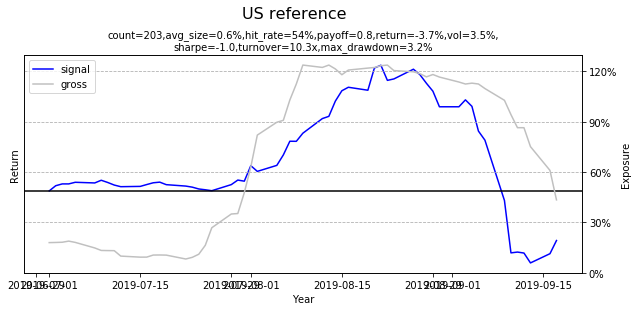

In [510]:
US_live.plot_account("US reference")

In [511]:
'''
US reference sizing and volatility
'''
print("US long size is "+str(_long_US_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("US long volatility is "+str(US1.loc[_long_US_live[-1].index]["30d_vol"].mean()))
print("US long number is "+str(_long_US_live[2].count(axis=1).mean()))
print("US short size is "+str(_short_US_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("US short volatility is "+str(US1.loc[_short_US_live[-1].index]["30d_vol"].mean()))
print("US short number is "+str(_short_US_live[2].count(axis=1).mean()))

US long size is 0.012410474834533685
US long volatility is 0.020851171668044982
US long number is 26.210526315789473
US short size is -0.009606398110422265
US short volatility is 0.016461738898315308
US short number is 16.45614035087719


In [519]:
Europe_live=signal(fundamental_df=Europe2,
                    price_df=Europe_price,
                   close_return_df=abs_return_Europe,
                    EAR_period=1,
                    entry=2,
                    long_criteria=((1,1000),(0.03,1000),None),
                    short_criteria=((-1000,-2),(-1000,-0.03),(5000,10000000)),
                    holding=30,
                    start=pd.Timestamp(2019,7,1),
                    end=pd.Timestamp(2019,9,17),
                    old_position=True,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [523]:
Europe_new=signal(fundamental_df=Europe2,
                   price_df=Europe_VWAP,
                  close_return_df=abs_return_Europe,
                   EAR_period=1,
                   entry=3,
                   long_criteria=((2,1000),(0.02,1000),None),
                   short_criteria=((-1000,-2),(-1000,-0.02),(5000,10000000)),
                   holding=30,
                   start=pd.Timestamp(2019,7,1),
                   end=pd.Timestamp(2019,9,17),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(True,(0.02,0.05),(-0.05,-0.02),2),
                  early_exit=False)

In [524]:
_long_Europe_live,_short_Europe_live,_alpha_Europe,_portfolio_Europe_live=Europe_new.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=65)

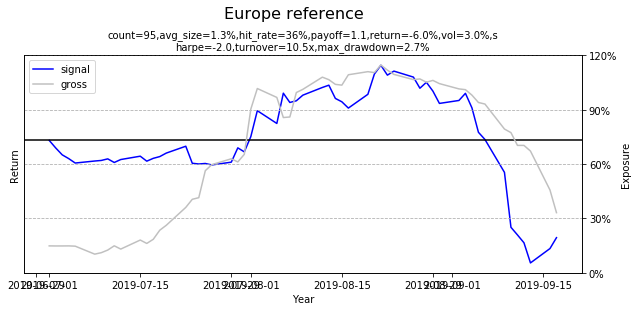

In [525]:
Europe_live.plot_account("Europe reference")

In [526]:
'''
Europe reference sizing and volatility
'''
print("Europe long size is "+str(_long_Europe_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Europe long volatility is "+str(Europe2.loc[_long_Europe_live[-1].index]["30d_vol"].mean()))
print("Europe long number is "+str(_long_Europe_live[2].count(axis=1).mean()))
print("Europe short size is "+str(_short_Europe_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Europe short volatility is "+str(Europe2.loc[_short_Europe_live[-1].index]["30d_vol"].mean()))
print("Europe short number is "+str(_short_Europe_live[2].count(axis=1).mean()))

Europe long size is 0.020525708575819646
Europe long volatility is 0.016376518426480167
Europe long number is 15.719298245614034
Europe short size is -0.012283169941996578
Europe short volatility is 0.013138115630322881
Europe short number is 13.350877192982455


In [528]:
Asia_live=signal(fundamental_df=Asia2,
                    price_df=Asia_price,
                 close_return_df=abs_return_Asia,
                    EAR_period=1,
                    entry=2,
                    long_criteria=((1,1000),(0.02,1000),None),
                    short_criteria=None,
                    holding=20,
                    start=pd.Timestamp(2019,7,1),
                    end=pd.Timestamp(2019,9,17),
                    old_position=True,
                    new_signal=False,
                    revision_adjust=(False,0.02,0.1,2),
                    early_exit=False)

In [533]:
Asia_new=signal(fundamental_df=Asia2,
                   price_df=Asia_VWAP,
                close_return_df=abs_return_Asia,
                   EAR_period=1,
                   entry=3,
                   long_criteria=((1,1000),(0.02,1000),None),
                   short_criteria=None,
                   holding=20,
                   start=pd.Timestamp(2019,7,1),
                   end=pd.Timestamp(2019,9,17),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(True,(0.02,0.05),(-0.05,-0.02),2),
                  early_exit=False)

In [534]:
_long_Asia_live,_short_Asia_live,_alpha_Asia_live,_portfolio_Asia_live=Asia_new.signal_account(stop=[8,8,"abs"],
                                                           gross=(30,0),
                                                           index_df=abs_return_index_Asia.loc[["AS51 Index","HSI Index",
                                                                                                "TPX Index","KOSPI Index",
                                                                                                "MXSG Index","TAMSCI Index"]].T,
                                                           net_level=0,
                                                           risk_parity=True,
                                                           liquidity=0.2,
                                                           capital=50)

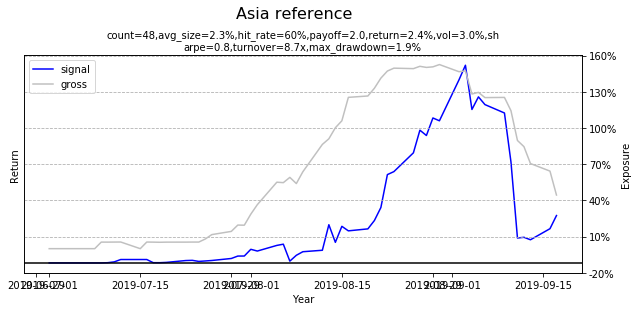

In [535]:
Asia_new.plot_account("Asia reference")

In [536]:
'''
Europe reference sizing and volatility
'''
print("Asia long size is "+str(_long_Asia_live[2].apply(lambda x:x.dropna().iloc[0],axis=0).mean()))
print("Asia long volatility is "+str(Asia2.loc[_long_Asia_live[-1].index]["30d_vol"].mean()))
print("Asia long number is "+str(_long_Asia_live[2].count(axis=1).mean()))




Asia long size is 0.018774946057680538
Asia long volatility is 0.020420164184614707
Asia long number is 17.087719298245613


# 9. Holding period analysis

In [355]:
''' 
US signal in the form of fundamental_df
'''
US_long=US1[["Date","Supersector","Revision_real"]]
US_long["EAR"]=US_long.apply(lambda x:EAR_calc(x.name[0],x.name[1],abs_return_US,2,30),axis=1)
US_long=US_sector[(US_sector["Revision_real"]>0.05)&(US_sector["EAR"]>2)]

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [356]:
def signal_day_transform(signal_df,return_df,EAR_period):
    signal_day=pd.DataFrame()
    for i in signal_df.index:
        if type(i[2])==str:
            column_day=return_df.loc[i[0]].loc[i[1]:i[2]].iloc[EAR_period+1:EAR_period+61]
        else:
            column_day=return_df.loc[i[0]].loc[i[1]:].iloc[EAR_period+1:EAR_period+61]
        column_day.index=list(range(1,column_day.shape[0]+1))
        signal_day=pd.concat([signal_day,column_day],axis=1)
        
    signal_day.columns=signal_df.index
    return signal_day

In [357]:
US_long_day=signal_day_transform(US_long,rel_return_US,1)

In [358]:
US_long_day_cum=(1+US_long_day).cumprod()-1

In [522]:
def plot_day_signal_by_year(signal_day,signal_df,sector):
    if sector=="all":
        pass
    else:
        sector_row=signal_df["Supersector"]
        signal_day=signal_day.loc[:,sector_row==sector]
    
    signal_day_cum=(1+signal_day).cumprod()-1
    
    year_row=signal_day_cum.apply(lambda x:int(x.name[1][-4:]),axis=0)
    year_list=sorted(list(set(year_row)))
    
    record_dict={}
    
    counter=0
    fig,ax=plt.subplots(round(len(year_list)/2)+1,2,figsize=(15,25))
    for i in year_list:
        ax[int(counter/2),counter%2].plot(signal_day_cum.loc[:,year_row==i].mean(axis=1))
        max_point=int(signal_day_cum.loc[:,year_row==i].mean(axis=1).loc[signal_day_cum.loc[:,year_row==i]\
                                                               .mean(axis=1)==signal_day_cum.\
                                                               loc[:,year_row==i].mean(axis=1).max()].index.values)
        ax[int(counter/2),counter%2].set_title(str(i)+'; '+str(signal_day_cum.loc[:,year_row==i].shape[1])+' signals; '+\
                                               'day'+str(max_point))
        counter+=1
        record_dict[i]=max_point
        
    plt.suptitle(sector,y=0.9,fontsize=20)
    plt.show()  
    return record_dict
    
    

In [518]:
def plot_day_signal_by_sector(signal_day,signal_df):

    sector_row=signal_df["Supersector"]
    
    signal_day_cum=(1+signal_day).cumprod()-1
    
    sector_list=sector_row.unique()
    
    counter=0
    
    record_dict={}
    fig,ax=plt.subplots(round(len(sector_list)/2)+1,2,figsize=(15,35))
    
    for i in sector_list:
        if type(i)==str:
            ax[int(counter/2),counter%2].plot(signal_day_cum.loc[:,sector_row==i].mean(axis=1))
            max_point=int(signal_day_cum.loc[:,sector_row==i].mean(axis=1).loc[signal_day_cum.loc[:,sector_row==i]\
                                                                   .mean(axis=1)==signal_day_cum.\
                                                                   loc[:,sector_row==i].mean(axis=1).max()].index.values)        

            ax[int(counter/2),counter%2].set_title(str(i)+'; '+str(signal_day_cum.loc[:,sector_row==i].shape[1])+' signals; '+\
                                                  'day'+str(max_point))
            counter+=1
            record_dict[i]=max_point
        else:
            pass

    plt.suptitle('All',y=0.9,fontsize=20)
    plt.show()    
    return record_dict
    
    

# 10 - single stock drawdown analysis

In [362]:
def max_dd_stock(return_series,long):
    if long==True:
        account_curve=(1+return_series).cumprod()-1
    else:
        account_curve=(1-return_series).cumprod()-1
    max_dd=-((1+account_curve)-(1+account_curve).cummax(axis=0)).expanding().min().min()
    return max_dd

In [384]:
def stock_dd_df(signal_return_df,long):
    dd_series=signal_return_df.apply(lambda x:max_dd_stock(x,long),axis=0)
    dd_df=dd_series.to_frame()
    dd_df['Quarter']=dd_df.apply(lambda x:pd.offsets.BQuarterEnd().rollforward(datetime.strptime(x.name[1],"%d/%b/%Y")),axis=1)
    return dd_df
    

In [446]:
Europe_long_copy=Europe_dd.long_df.copy()
Europe_short_copy=Europe_dd.short_df.copy()

US_long_copy=US_dd.long_df.copy()
US_short_copy=US_dd.short_df.copy()

In [447]:

Europe_dd_long_series=stock_dd_df(Europe_long_copy,True)
Europe_dd_short_series=stock_dd_df(Europe_short_copy,False)

US_dd_long_series=stock_dd_df(US_long_copy,True)
US_dd_short_series=stock_dd_df(US_short_copy,False)

In [448]:
mean_dd=pd.concat([Europe_dd_long_series.groupby(["Quarter"]).apply(np.mean),\
                   Europe_dd_short_series.groupby(["Quarter"]).apply(np.mean),\
                  US_dd_long_series.groupby(["Quarter"]).apply(np.mean),\
                  US_dd_short_series.groupby(["Quarter"]).apply(np.mean)],axis=1)
mean_dd.columns=["Europe_long","Europe_short","US_long","US_short"]

In [450]:
median_dd=pd.concat([Europe_dd_long_series.groupby(["Quarter"]).apply(np.median),\
                   Europe_dd_short_series.groupby(["Quarter"]).apply(np.median),\
                  US_dd_long_series.groupby(["Quarter"]).apply(np.median),\
                  US_dd_short_series.groupby(["Quarter"]).apply(np.median)],axis=1)
median_dd.columns=["Europe_long","Europe_short","US_long","US_short"]

In [453]:
mean_dd.iloc[1:,:].to_csv("mean_dd.csv")

In [454]:
median_dd.iloc[1:,:].to_csv("median_dd.csv")

In [426]:
ab=stock_dd_df(long_copy,True)

In [433]:
bc=stock_dd_df(short_copy,False)

In [434]:
bc.groupby(bc["Quarter"]).apply(np.mean)

,0
Quarter,
2009-12-31,0.054115
2010-03-31,0.146732
2010-06-30,0.122474
2010-09-30,0.133589
2010-12-31,0.140965
2011-03-31,0.095687
2011-06-30,0.084302
2011-09-30,0.185083
2011-12-30,0.140409


In [436]:
sample=bc.groupby(bc["Quarter"]).apply(np.mean).sort_index()+ab.groupby(ab["Quarter"]).apply(np.mean).sort_index()

In [437]:
sample.describe()

,0
count,40.000000
mean,0.212705
std,0.048657
min,0.112099
25%,0.176704
50%,0.201439
75%,0.231528
max,0.386484


In [418]:
long_copy=US_dd.long_df.copy()
short_copy=US_dd.short_df.copy()

In [371]:
long_copy.apply(lambda x:max_dd_stock(x,True),axis=0)

1COV GR   24/Oct/2017  20/Feb/2018  29/Dec/2017    0.060729
A3M SM    28/Oct/2010  24/Feb/2011  31/Dec/2010    0.212446
          25/Jul/2013  31/Oct/2013  30/Sep/2013    0.110544
          31/Oct/2013  27/Feb/2014  31/Dec/2013    0.116558
          23/Oct/2014  26/Feb/2015  31/Dec/2014    0.119530
AAK SS    23/Apr/2019  16/Jul/2019  28/Jun/2019    0.044517
AAL LN    25/Jul/2014  13/Feb/2015  30/Sep/2014    0.068991
ABBN SW   18/Feb/2010  22/Apr/2010  31/Mar/2010    0.020729
          22/Jul/2010  28/Oct/2010  30/Sep/2010    0.115265
          17/Apr/2019  25/Jul/2019  28/Jun/2019    0.096362
ABF LN    20/Apr/2010  09/Nov/2010  30/Jun/2010    0.110716
ABIT BB   12/Aug/2010  03/Nov/2010  30/Sep/2010    0.040469
          08/Mar/2012  30/Apr/2012  30/Mar/2012    0.029161
AC FP     26/Aug/2010  23/Feb/2011  30/Sep/2010    0.033976
ACA FP    08/Nov/2016  15/Feb/2017  30/Dec/2016    0.035569
          03/Aug/2018  07/Nov/2018  28/Sep/2018    0.060751
ACX SM    01/Mar/2017  27/Apr/2017  31/M

In [443]:
Europe_dd=signal(fundamental_df=Europe2,
                   price_df=Europe_VWAP,
                   close_return_df=abs_return_Europe,
                   EAR_period=1,
                   entry=3,
                   long_criteria=((2,1000),(0.02,1000),None),
                   short_criteria=((-1000,-2),(-1000,-0.02),None),
                   holding=30,
                   start=pd.Timestamp(2010,1,1),
                   end=pd.Timestamp(2019,9,17),
                   old_position=False,
                   new_signal=True,
                   revision_adjust=(False,(0.02,0.05),(-0.05,-0.02),2),
                  early_exit=False)

In [444]:
_long_Europe,_short_Europe,_alpha_Europe,_portfolio_Europe=Europe_dd.signal_account(stop=None,
                                                           gross=(30,15),
                                                           index_df=abs_return_index_Europe.loc["SX5E Index"].to_frame('Europe'),
                                                           net_level=0,
                                                           risk_parity=False,
                                                           liquidity=0.2,
                                                           capital=60)

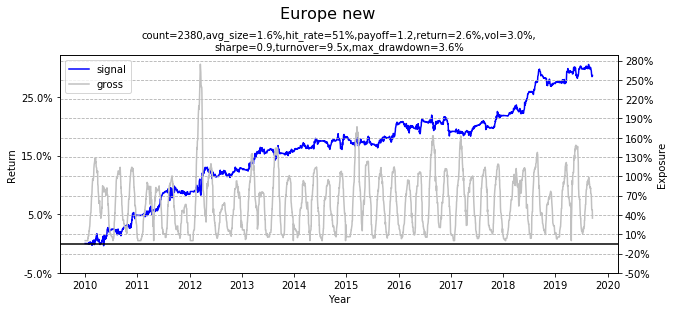

In [456]:
plot_signal("Europe new ", [10,4],Europe_dd.portfolio_account)

In [415]:
US_dd=signal(fundamental_df=US1,
              price_df=US_VWAP,
              close_return_df=abs_return_US,
              EAR_period=2,
              entry=3,
              long_criteria=((2,1000),(0.02,1000),None),
              short_criteria=((-1000,-2),(-1000,-0.02),None),
              holding=30,
              start=pd.Timestamp(2010,1,1),
              end=pd.Timestamp(2019,9,17),
              old_position=True,
              new_signal=True,
              revision_adjust=(None,(0.05,0.2),(-0.03,-0.1),2),
              early_exit=False)

In [416]:
_long_US,_short_US,_alpha_US,_portfolio_US=US_dd.signal_account(stop=None,
                                                           gross=(30,15),
                                                           index_df=(0.5*abs_return_index_US.loc["SPX Index"]+\
                                                          0.5*abs_return_index_US.loc["RTY Index"]).to_frame("US_index"),
                                                           net_level=0,
                                                           risk_parity=False,
                                                           liquidity=0.2,
                                                           capital=60)

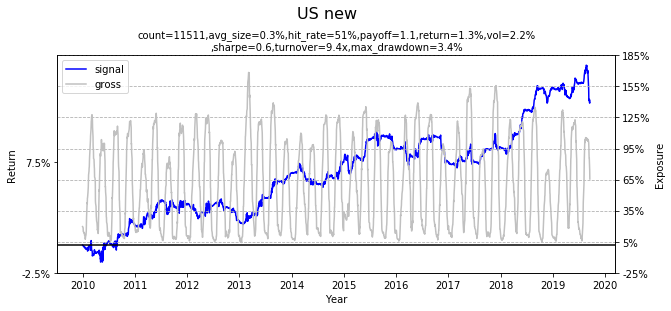

In [417]:
plot_signal("US new", [10,4],US_dd.portfolio_account)